In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# 데이터 로드

In [ ]:
import matplotlib.pyplot as plt # 파이썬의 대표적인 그래픽 라이브러리.
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.fft import fft
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [ ]:
pip install gensim
pip install scipy.stats

In [ ]:


train = pd.read_csv('.\\train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('.\\test.csv').drop(columns=['SAMPLE_ID'])

In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday



# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}
for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)


Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.80it/s]
C:\Users\jenny\AppData\Local\Temp\ipykernel_20808\360312887.py:31: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  train.fillna(train.mean(), inplace=True)
C:\Users\jenny\AppData\Local\Temp\ipykernel_20808\360312887.py:32: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  test.fillna(train.mean(), inplace=True)


In [ ]:

# DIST에 로그 변환을 적용하되, 0인 값에 대해서는 np.log1p (로그 변환 후 1을 더함)를 사용하여 변환 

train['log_DIST'] = np.log1p(train['DIST'])
test['log_DIST'] = np.log1p(test['DIST'])
train.drop(columns=['DIST'], inplace=True)
test.drop(columns=['DIST'], inplace=True)

# 새로운 피처 삽입

In [6]:

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # AIR_TEMPERATURE와 관련된 비선형 피처 생성
    df['TEMP_SQUARE'] = df['AIR_TEMPERATURE'] ** 2
    df['TEMP_LOG'] = np.log1p(df['AIR_TEMPERATURE'] + abs(df['AIR_TEMPERATURE'].min()) + 1)
    df['TEMP_SQRT'] = np.sqrt(df['AIR_TEMPERATURE'] + abs(df['AIR_TEMPERATURE'].min()))

    # 바람의 크기와 방향을 나타내는 피처 생성
    df['WIND_MAGNITUDE'] = np.sqrt(df['U_WIND']**2 + df['V_WIND']**2)
    df['WIND_DIRECTION'] = np.arctan2(df['V_WIND'], df['U_WIND'])
    
add_features(train)
add_features(test)  


In [11]:
def feature_engineering_advanced(df):
    # 2. 온도의 변화율 변화율
    df['TEMP_DIFF'] = df['AIR_TEMPERATURE'].diff()
    df['TEMP_DIFF_DIFF'] = df['TEMP_DIFF'].diff()
    
    
    # 4. 온도와 풍향의 상호작용
    df['TEMP_WIND_DIRECTION_INTERACTION'] = df['AIR_TEMPERATURE'] * np.cos(df['WIND_DIRECTION'])
    
    # 5. 바람의 복합성분
    df['WIND_COMPOSITE_SUM'] = df['U_WIND'] + df['V_WIND']
    df['WIND_COMPOSITE_DIFF'] = df['U_WIND'] - df['V_WIND']
    
    # 6. 지수 가중 이동 표준편차
    df['TEMP_EWSTD'] = df['AIR_TEMPERATURE'].ewm(span=24).std()
    
    # 7. 온도와 바람의 비율
    df['TEMP_WIND_RATIO'] = df['AIR_TEMPERATURE'] / (df['WIND_MAGNITUDE'] + 1e-3)  # 분모가 0이 되는 것을 방지
    
    # 8. 시간대별 풍향의 변화율
    df['WIND_DIRECTION_DIFF'] = df['WIND_DIRECTION'].diff()
    
    # 9. 바람의 동서/남북 성분
    df['WIND_EAST_WEST'] = np.sin(df['WIND_DIRECTION'])
    df['WIND_SOUTH_NORTH'] = np.cos(df['WIND_DIRECTION'])
    
    # 10. 온도의 Z-score
    temp_mean = df['AIR_TEMPERATURE'].mean()
    temp_std = df['AIR_TEMPERATURE'].std()
    df['TEMP_ZSCORE'] = (df['AIR_TEMPERATURE'] - temp_mean) / temp_std
    
    # 11. 시간대별 온도 변화율
    df['TEMP_DIFF'] = df['AIR_TEMPERATURE'].diff()

    
    # 13. 온도와 풍속의 차이
    df['TEMP_WIND_DIFF'] = df['AIR_TEMPERATURE'] - df['WIND_MAGNITUDE']
    
    # 15. 온도의 누적 합
    df['TEMP_CUMSUM'] = df['AIR_TEMPERATURE'].cumsum()

 
    # 18. 기타 피처 생성
    df['TEMP_SQUARED'] = df['AIR_TEMPERATURE'] ** 2
    df['TEMP_UWIND_MULTIPLY'] = df['AIR_TEMPERATURE'] * df['U_WIND']
    df['TEMP_VWIND_MULTIPLY'] = df['AIR_TEMPERATURE'] * df['V_WIND']
    df['TEMP_WINDMAG_MULTIPLY'] = df['AIR_TEMPERATURE'] * df['WIND_MAGNITUDE']
   
    
    # 21. 바람의 크기와 방향을 나타내는 피처 생성
    df['WIND_MAGNITUDE'] = np.sqrt(df['U_WIND']**2 + df['V_WIND']**2)
    df['WIND_DIRECTION'] = np.arctan2(df['V_WIND'], df['U_WIND'])


def cihour(df):
      # 1. 시간대별 최대/최소 온도
    df['TEMP_MAX_BY_HOUR'] = df.groupby('CI_HOUR')['AIR_TEMPERATURE'].transform('max')
    df['TEMP_MIN_BY_HOUR'] = df.groupby('CI_HOUR')['AIR_TEMPERATURE'].transform('min')

     # 17. 시간대의 sin, cos 변환
    hours_in_day = 24
    df['HOUR_SIN'] = np.sin(2 * np.pi * df['CI_HOUR'] / hours_in_day)
    df['HOUR_COS'] = np.cos(2 * np.pi * df['CI_HOUR'] / hours_in_day)
    
    df['CI_DAY'] = df['CI_HOUR'] % 24
    df['CI_MONTH'] = (df['CI_HOUR'] // 24) % 12
    df['WIND_DIRECTION_MEDIAN_BY_HOUR'] = df.groupby('CI_HOUR')['WIND_DIRECTION'].transform('median')
    df['WIND_HOUR_INTERACTION'] = df['CI_HOUR'] * df['WIND_MAGNITUDE']
    df['WIND_DIRECTION_MEAN_BY_HOUR'] = df.groupby('CI_HOUR')['WIND_DIRECTION'].transform('mean')
    df['WIND_SUM_BY_HOUR'] = df.groupby('CI_HOUR')['WIND_MAGNITUDE'].transform('sum')
    df['TEMP_HOUR_INTERACTION'] = df['CI_HOUR'] * df['AIR_TEMPERATURE']
    df['TEMP_RANGE_BY_HOUR'] = df.groupby('CI_HOUR')['AIR_TEMPERATURE'].transform('max') - df.groupby('CI_HOUR')['AIR_TEMPERATURE'].transform('min')
    
    # 3. 시간대별 풍속의 중앙값
    df['WIND_MEDIAN_BY_HOUR'] = df.groupby('CI_HOUR')['WIND_MAGNITUDE'].transform('median')
# Sample execution
feature_engineering_advanced(train)
feature_engineering_advanced(test)


In [14]:

def waiting_time(df):
    df['WAITING_TIME_FACTOR'] = df['DEADWEIGHT'] / df['LENGTH']
    return df
waiting_time(train)
waiting_time(test)



# datetime 컬럼 제거

train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)
# 갱신된 데이터프레임 출력
print(train.head())
print(test.head())
# # 바람 방향 계산 함수

# Polynomial feature example: Square of DEADWEIGHT
train['DEADWEIGHT_sq'] = train['DEADWEIGHT']**2

# Polynomial feature example: Square of DEADWEIGHT
test['DEADWEIGHT_sq'] = test['DEADWEIGHT']**2


def apply_weight_based_on_day(day):
    if day in [0, 1, 2, 3]:  # 월화수목금
        return 1
    elif day == 4:  # 토요일
        return 1.17
    elif day == 5:  # 토요일
        return 3.23
    else:  # 일요일
        return 2.07

train['day_weight'] = train['weekday'].apply(apply_weight_based_on_day)
test['day_weight'] = test['weekday'].apply(apply_weight_based_on_day)


# # 아웃라이어 제거는 트레인 데이터에만 적용해도 될 것 같다. 
# preprocess_wind_vector_and_remove_outliers(train)
test['wind_speed'] = np.sqrt((test['U_WIND']**2 + test['V_WIND']**2))

y_train = train['CI_HOUR']

# 바람의 방향 (Direction) 계산
def calculate_wind_direction(df):
    # 아크탄젠트 함수를 사용하여 방향을 라디안 값으로 계산
    wind_direction_rad = np.arctan2(df['V_WIND'], df['U_WIND'])
    
    # 라디안을 도(degree)로 변환
    df['wind_direction_degrees'] = np.degrees(wind_direction_rad)
    
    # 방향값을 0~360 범위로 조정
    df['wind_direction_degrees'] = (df['wind_direction_degrees'] + 360) % 360

    

# 함수를 사용하여 바람의 방향을 계산하고 데이터프레임에 추가
calculate_wind_direction(train)
calculate_wind_direction(test)


# 2023_10_28 컨테이너가 아닌경우 나머지의 평균값으로 대체
def shipcategory(df):
    df['SHIP_TYPE_CATEGORY'] = df['SHIP_TYPE_CATEGORY'].apply(lambda x: 40  if x == 'Container' else 76.83)
    return df
shipcategory(train)
shipcategory(test)

   ARI_CO  ARI_PO  SHIP_TYPE_CATEGORY     ID  BREADTH  BUILT  DEADWEIGHT  \
0      17      21                   2  24710     30.0     24       24300   
1       7      81                   0  23140     30.0     13       35900   
2       4      14                   2  19009     50.0     12      146000   
3       8     101                   2  24048     20.0     18        6910   
4      17      21                   2    911     50.0     10      116000   

   DEPTH  DRAUGHT      GT  ...  WIND_EAST_WEST  WIND_SOUTH_NORTH  \
0   10.0     10.0   16700  ...       -0.666770         -0.745264   
1   10.0     10.0   23500  ...       -0.666770         -0.745264   
2   30.0     20.0  140000  ...       -0.666770         -0.745264   
3   10.0     10.0    5400  ...       -0.451697         -0.892171   
4   20.0     10.0   96600  ...       -0.994977         -0.100104   

    TEMP_ZSCORE  TEMP_WIND_DIFF  TEMP_CUMSUM  TEMP_SQUARED  \
0  4.794571e-16       18.467256    18.862968     355.81158   
1  4.79457

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,...,TEMP_CUMSUM,TEMP_SQUARED,TEMP_UWIND_MULTIPLY,TEMP_VWIND_MULTIPLY,TEMP_WINDMAG_MULTIPLY,WAITING_TIME_FACTOR,DEADWEIGHT_sq,day_weight,wind_speed,wind_direction_degrees
0,18,22,76.83,9789,50.0,18,117000,30.0,20.0,109000,...,2.710000e+01,734.41000,10.027000,44.17300,45.296740,344.117647,13689000000,1.00,1.671466,77.210928
1,5,91,76.83,4185,10.0,13,3810,10.0,10.0,2560,...,4.130000e+01,201.64000,-39.618000,-33.08600,51.616561,47.625000,14516100,1.00,3.634969,219.866116
2,5,46,76.83,5579,20.0,26,10900,10.0,10.0,8440,...,5.060000e+01,86.49000,0.372000,-45.66300,45.664515,77.857143,118810000,1.00,4.910163,270.466758
3,3,20,76.83,735,30.0,9,55800,20.0,10.0,31500,...,6.946297e+01,355.81158,-5.562876,-4.97697,7.464303,293.684211,3113640000,1.00,0.395712,221.818222
4,9,67,76.83,848,30.0,19,39800,20.0,10.0,33000,...,8.832594e+01,355.81158,-5.562876,-4.97697,7.464303,180.909091,1584040000,1.00,0.395712,221.818222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220486,2,77,76.83,4559,60.0,15,298000,30.0,20.0,151000,...,4.164912e+06,355.81158,-5.562876,-4.97697,7.464303,903.030303,88804000000,1.00,0.395712,221.818222
220487,3,24,76.83,15839,30.0,9,80500,20.0,10.0,42700,...,4.164931e+06,355.81158,-5.562876,-4.97697,7.464303,365.909091,6480250000,1.00,0.395712,221.818222
220488,9,89,76.83,19352,10.0,14,1200,0.0,0.0,500,...,4.164958e+06,750.76000,-78.638000,33.42800,85.448032,20.000000,1440000,2.07,3.118541,156.970281
220489,5,63,76.83,2087,10.0,27,3420,10.0,0.0,2000,...,4.164967e+06,67.24000,-21.730000,-5.24800,22.354740,42.750000,11696400,1.00,2.726188,193.577479


# 모델 학습 및 특성 중요도 확인


Model Tune for CatBoost.
Learning rate set to 0.105174
0:	learn: 168.1665530	total: 219ms	remaining: 3m 38s
1:	learn: 165.9646148	total: 256ms	remaining: 2m 7s
2:	learn: 164.2010183	total: 289ms	remaining: 1m 35s
3:	learn: 162.7123975	total: 320ms	remaining: 1m 19s
4:	learn: 161.4574945	total: 354ms	remaining: 1m 10s
5:	learn: 160.4760463	total: 386ms	remaining: 1m 3s
6:	learn: 159.5375252	total: 420ms	remaining: 59.5s
7:	learn: 158.6889487	total: 457ms	remaining: 56.6s
8:	learn: 158.0032984	total: 494ms	remaining: 54.4s
9:	learn: 157.3102485	total: 528ms	remaining: 52.2s
10:	learn: 156.8254844	total: 563ms	remaining: 50.6s
11:	learn: 156.4259369	total: 596ms	remaining: 49.1s
12:	learn: 156.0393872	total: 629ms	remaining: 47.8s
13:	learn: 155.6362483	total: 659ms	remaining: 46.4s
14:	learn: 155.2699098	total: 692ms	remaining: 45.5s
15:	learn: 154.9604013	total: 725ms	remaining: 44.6s
16:	learn: 154.6452334	total: 751ms	remaining: 43.4s
17:	learn: 154.3169893	total: 779ms	remaining: 42.

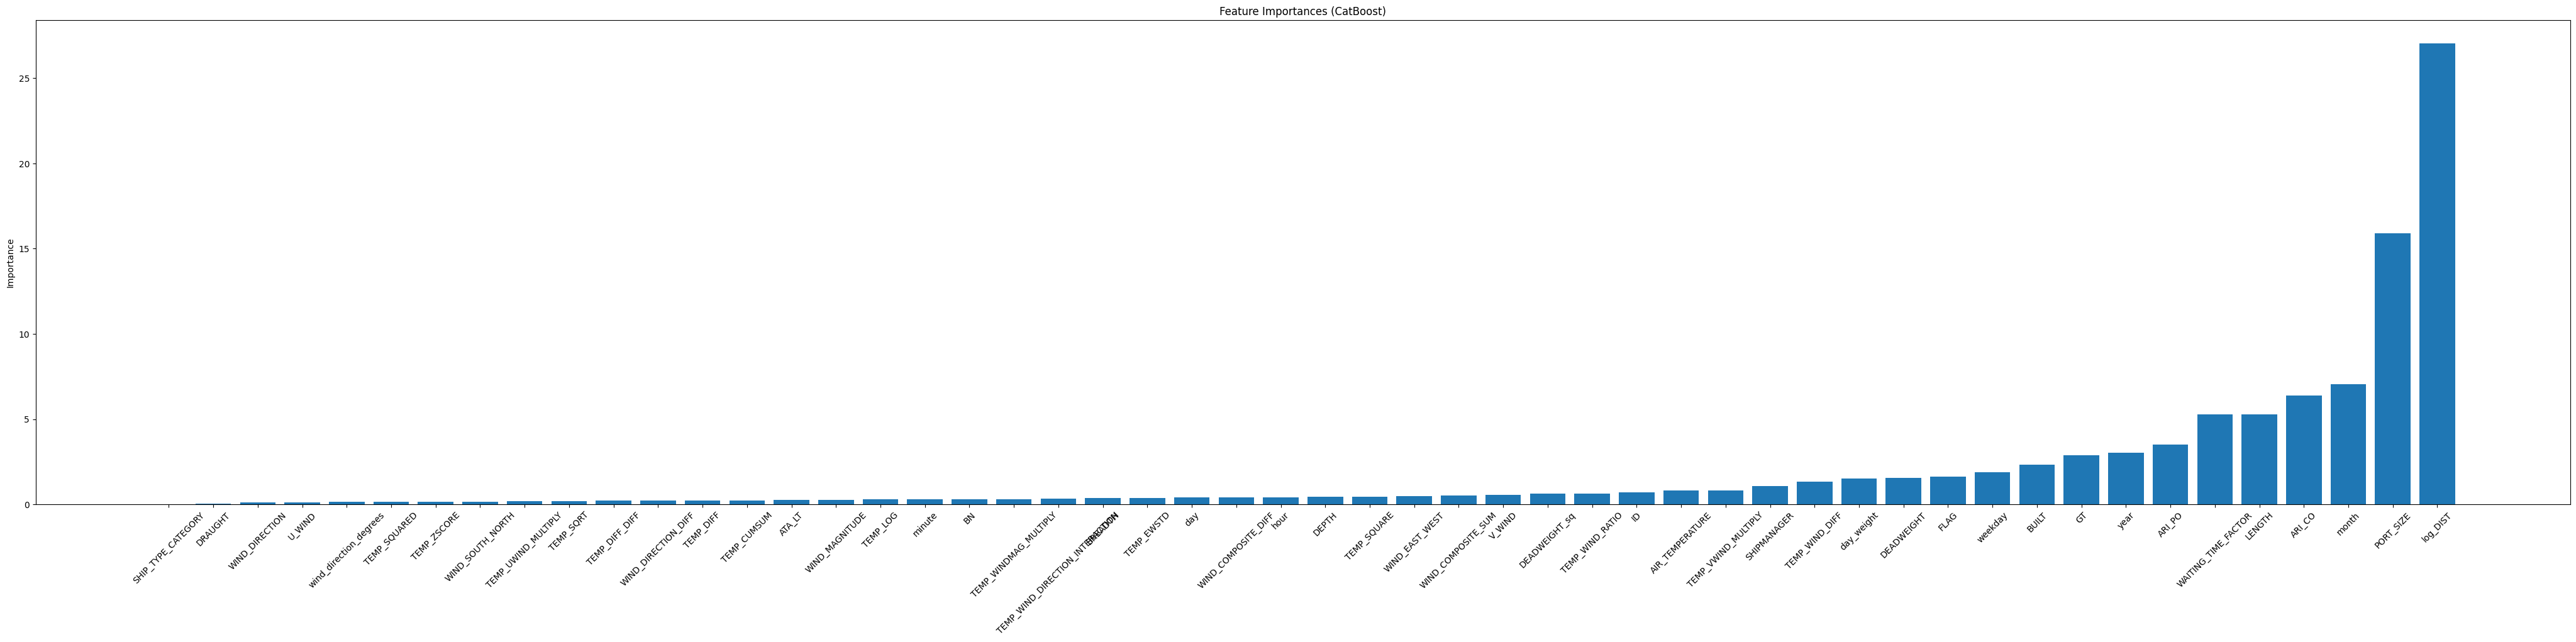

In [15]:

import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    # 그래프 크기와 타이틀 변경
    plt.figure(figsize=(len(X_train.columns), 10))  # 가로 세로 길이 변경
    plt.title(f"Feature Importances ({model_name})")

    # barh를 bar로 변경하여 세로 막대 그래프 생성
    plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')

    # xticks로 변경하여 x축에 특성 이름 표시
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=45)  # rotation 옵션으로 레이블 회전

    # x축 레이블 변경
    plt.ylabel('Importance')
    plt.show()

    return model, feature_importances

y_train = train['CI_HOUR']
X_train = train.drop(columns='CI_HOUR')



catboost_model, catboost_feature_importances = train_and_evaluate(CatBoostRegressor(), 'CatBoost', X_train, y_train)


## 특성 중요도로부터 Feature Selection

In [16]:

# 특성 중요도를 내림차순으로 정렬
sorted_importances = sorted(zip(catboost_feature_importances, X_train.columns), reverse=True)

# 정렬된 특성 중요도를 출력
for importance, feature_name in sorted_importances:
    print(f"Feature: {feature_name}, Importance: {importance}")

Feature: log_DIST, Importance: 27.049518366498546
Feature: PORT_SIZE, Importance: 15.888081790399198
Feature: month, Importance: 7.04960450620476
Feature: ARI_CO, Importance: 6.385030391670788
Feature: LENGTH, Importance: 5.287916092175976
Feature: WAITING_TIME_FACTOR, Importance: 5.263148289184981
Feature: ARI_PO, Importance: 3.4919773877806666
Feature: year, Importance: 3.03525395970699
Feature: GT, Importance: 2.890000694962461
Feature: BUILT, Importance: 2.3141842482725896
Feature: weekday, Importance: 1.8823865972836633
Feature: FLAG, Importance: 1.6412017552799827
Feature: DEADWEIGHT, Importance: 1.5447948700657406
Feature: day_weight, Importance: 1.5315620514320354
Feature: TEMP_WIND_DIFF, Importance: 1.351186681222823
Feature: SHIPMANAGER, Importance: 1.0705278615057574
Feature: TEMP_VWIND_MULTIPLY, Importance: 0.8233469920772833
Feature: AIR_TEMPERATURE, Importance: 0.8145521824902294
Feature: ID, Importance: 0.6924501422050835
Feature: TEMP_WIND_RATIO, Importance: 0.634725192

In [17]:

# "CI_HOUR"와 다른 피처들 간의 상관 계수 계산
correlations = train.corr()['CI_HOUR'].drop('CI_HOUR')

# 상관 계수 출력
print(correlations)

ARI_CO                             0.005224
ARI_PO                            -0.000459
SHIP_TYPE_CATEGORY                      NaN
ID                                -0.008185
BREADTH                            0.043711
BUILT                              0.001756
DEADWEIGHT                         0.077954
DEPTH                              0.051760
DRAUGHT                            0.040309
GT                                 0.059661
LENGTH                             0.035334
SHIPMANAGER                        0.003544
FLAG                               0.021199
U_WIND                            -0.009600
V_WIND                             0.013712
AIR_TEMPERATURE                    0.028166
BN                                -0.012820
ATA_LT                             0.000090
PORT_SIZE                          0.020635
year                               0.021253
month                              0.004286
day                                0.000370
hour                            

In [18]:
sorted_correlations = correlations.sort_values(ascending=False)
print(sorted_correlations)


log_DIST                           0.278319
day_weight                         0.164882
weekday                            0.111632
WAITING_TIME_FACTOR                0.083392
DEADWEIGHT                         0.077954
DEADWEIGHT_sq                      0.073593
GT                                 0.059661
DEPTH                              0.051760
BREADTH                            0.043711
TEMP_SQUARE                        0.042679
TEMP_SQUARED                       0.042679
DRAUGHT                            0.040309
LENGTH                             0.035334
AIR_TEMPERATURE                    0.028166
TEMP_ZSCORE                        0.028166
TEMP_SQRT                          0.024711
TEMP_WIND_DIFF                     0.024696
WIND_EAST_WEST                     0.024063
WIND_DIRECTION                     0.023360
year                               0.021253
FLAG                               0.021199
TEMP_LOG                           0.021146
PORT_SIZE                       

In [19]:

X_train_reduced=X_train
X_test_reduced=test


## 모델 학습 및 평가

In [20]:


# 미리 설정한 하이퍼 파라미터

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

#'learning_rate': 0.015,

# 0.000005 
catboost_params = {
    'iterations': 40000,
    'depth': 10,
    'learning_rate': 0.02,
    'random_seed': 42,
    'subsample': 0.6432,
    'loss_function': 'MAE',
    'early_stopping_rounds': 1000,
    'verbose':True
}

# K-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

# 각 fold에 대해 처리
for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]


    # CatBoost 모델 생성 및 학습
    model = CatBoostRegressor(**catboost_params)
    model.fit(X_t, y_t, eval_set=(X_val, y_val), verbose=catboost_params['verbose'])

    # Validation set에 대한 예측 생성
    val_pred = model.predict(X_val)

    # MAE 점수 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # 테스트 데이터셋에 대한 예측 수행 후 저장
    test_pred = model.predict(X_test_reduced)  # 테스트 데이터를 X_train_reduced로 대체했습니다.
    test_pred = np.where(test_pred < 0, 0, test_pred)
    ensemble_predictions.append(test_pred)

    # 각 fold에서의 MAE 점수 출력
    print(mean_absolute_error(y_val, val_pred))

# K-fold 모든 예측의 평균을 계산하여 최종 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 최종 성능
print(f"Average MAE score: {np.mean(scores)}")

# 최종 예측 결과 출력
print("Final predictions:", final_predictions[:10])





Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 61.0122812	test: 59.9485506	best: 59.9485506 (0)	total: 151ms	remaining: 1h 40m 50s
1:	learn: 60.6383467	test: 59.5734036	best: 59.5734036 (1)	total: 275ms	remaining: 1h 31m 38s
2:	learn: 60.2486822	test: 59.1859583	best: 59.1859583 (2)	total: 397ms	remaining: 1h 28m 7s
3:	learn: 59.8982926	test: 58.8356037	best: 58.8356037 (3)	total: 523ms	remaining: 1h 27m 8s
4:	learn: 59.5515928	test: 58.4898763	best: 58.4898763 (4)	total: 655ms	remaining: 1h 27m 16s
5:	learn: 59.2258237	test: 58.1652503	best: 58.1652503 (5)	total: 786ms	remaining: 1h 27m 19s
6:	learn: 58.9106635	test: 57.8504393	best: 57.8504393 (6)	total: 909ms	remaining: 1h 26m 34s
7:	learn: 58.5846332	test: 57.5246754	best: 57.5246754 (7)	total: 1.04s	remaining: 1h 26m 23s
8:	learn: 58.2527782	test: 57.1913658	best: 57.1913658 (8)	total: 1.16s	remaining: 1h 25m 58s
9:	learn: 57.9626944	test: 56.9011656	best: 56.9011656 (9)	total: 1.29s	remaining: 1h 25m 47s
10:	learn: 57.6891519	test: 56.6286378	best: 56.6286378 (10)	t

Processing folds:  20%|██        | 1/5 [11:01<44:06, 661.51s/it]

44.225251173461224
0:	learn: 60.7217746	test: 61.3040004	best: 61.3040004 (0)	total: 167ms	remaining: 1h 51m 6s
1:	learn: 60.3342473	test: 60.9161693	best: 60.9161693 (1)	total: 334ms	remaining: 1h 51m 10s
2:	learn: 59.9433182	test: 60.5261808	best: 60.5261808 (2)	total: 521ms	remaining: 1h 55m 44s
3:	learn: 59.6040237	test: 60.1876952	best: 60.1876952 (3)	total: 651ms	remaining: 1h 48m 25s
4:	learn: 59.2596044	test: 59.8442641	best: 59.8442641 (4)	total: 821ms	remaining: 1h 49m 27s
5:	learn: 58.9371583	test: 59.5206215	best: 59.5206215 (5)	total: 999ms	remaining: 1h 50m 55s
6:	learn: 58.6096702	test: 59.1927032	best: 59.1927032 (6)	total: 1.18s	remaining: 1h 52m 3s
7:	learn: 58.3014656	test: 58.8877437	best: 58.8877437 (7)	total: 1.35s	remaining: 1h 52m 11s
8:	learn: 57.9845396	test: 58.5738529	best: 58.5738529 (8)	total: 1.52s	remaining: 1h 52m 50s
9:	learn: 57.6900983	test: 58.2808013	best: 58.2808013 (9)	total: 1.7s	remaining: 1h 53m 27s
10:	learn: 57.4006401	test: 57.9942511	best:

Processing folds:  40%|████      | 2/5 [18:50<27:24, 548.30s/it]

45.534804776677
0:	learn: 60.6514102	test: 61.5919873	best: 61.5919873 (0)	total: 223ms	remaining: 2h 28m 25s
1:	learn: 60.2668118	test: 61.2052146	best: 61.2052146 (1)	total: 391ms	remaining: 2h 10m 17s
2:	learn: 59.8784039	test: 60.8134168	best: 60.8134168 (2)	total: 605ms	remaining: 2h 14m 28s
3:	learn: 59.5303589	test: 60.4656437	best: 60.4656437 (3)	total: 788ms	remaining: 2h 11m 20s
4:	learn: 59.1859608	test: 60.1206841	best: 60.1206841 (4)	total: 974ms	remaining: 2h 9m 48s
5:	learn: 58.8546971	test: 59.7895556	best: 59.7895556 (5)	total: 1.15s	remaining: 2h 7m 34s
6:	learn: 58.5421408	test: 59.4745584	best: 59.4745584 (6)	total: 1.32s	remaining: 2h 5m 51s
7:	learn: 58.2166664	test: 59.1475412	best: 59.1475412 (7)	total: 1.49s	remaining: 2h 4m 30s
8:	learn: 57.8901315	test: 58.8212959	best: 58.8212959 (8)	total: 1.67s	remaining: 2h 3m 41s
9:	learn: 57.5998665	test: 58.5287783	best: 58.5287783 (9)	total: 1.85s	remaining: 2h 3m 32s
10:	learn: 57.3427285	test: 58.2681726	best: 58.26

Processing folds:  60%|██████    | 3/5 [27:59<18:17, 548.63s/it]

45.4590337824095
0:	learn: 60.8545383	test: 60.7785793	best: 60.7785793 (0)	total: 180ms	remaining: 1h 59m 41s
1:	learn: 60.4685520	test: 60.3944293	best: 60.3944293 (1)	total: 357ms	remaining: 1h 59m 8s
2:	learn: 60.0799301	test: 60.0074553	best: 60.0074553 (2)	total: 561ms	remaining: 2h 4m 35s
3:	learn: 59.7434873	test: 59.6721633	best: 59.6721633 (3)	total: 704ms	remaining: 1h 57m 14s
4:	learn: 59.3979622	test: 59.3277815	best: 59.3277815 (4)	total: 895ms	remaining: 1h 59m 19s
5:	learn: 59.0657167	test: 58.9983474	best: 58.9983474 (5)	total: 1.08s	remaining: 2h 20s
6:	learn: 58.7384760	test: 58.6744017	best: 58.6744017 (6)	total: 1.27s	remaining: 2h 1m 2s
7:	learn: 58.4382215	test: 58.3786170	best: 58.3786170 (7)	total: 1.46s	remaining: 2h 1m 32s
8:	learn: 58.1226566	test: 58.0637710	best: 58.0637710 (8)	total: 1.64s	remaining: 2h 1m 41s
9:	learn: 57.8280261	test: 57.7714073	best: 57.7714073 (9)	total: 1.82s	remaining: 2h 1m 12s
10:	learn: 57.5533241	test: 57.4970761	best: 57.497076

Processing folds:  80%|████████  | 4/5 [37:12<09:10, 550.16s/it]

44.832804724356215
0:	learn: 60.9147472	test: 60.5318654	best: 60.5318654 (0)	total: 156ms	remaining: 1h 44m
1:	learn: 60.5351335	test: 60.1530636	best: 60.1530636 (1)	total: 320ms	remaining: 1h 46m 35s
2:	learn: 60.1437091	test: 59.7643020	best: 59.7643020 (2)	total: 490ms	remaining: 1h 48m 52s
3:	learn: 59.8079155	test: 59.4288274	best: 59.4288274 (3)	total: 611ms	remaining: 1h 41m 52s
4:	learn: 59.4633362	test: 59.0865484	best: 59.0865484 (4)	total: 772ms	remaining: 1h 42m 51s
5:	learn: 59.1321478	test: 58.7563044	best: 58.7563044 (5)	total: 939ms	remaining: 1h 44m 18s
6:	learn: 58.8050969	test: 58.4296699	best: 58.4296699 (6)	total: 1.1s	remaining: 1h 45m 2s
7:	learn: 58.4944873	test: 58.1214923	best: 58.1214923 (7)	total: 1.27s	remaining: 1h 45m 45s
8:	learn: 58.1801365	test: 57.8098418	best: 57.8098418 (8)	total: 1.44s	remaining: 1h 46m 47s
9:	learn: 57.8869452	test: 57.5169764	best: 57.5169764 (9)	total: 1.61s	remaining: 1h 47m 14s
10:	learn: 57.6113401	test: 57.2434899	best: 57

Processing folds: 100%|██████████| 5/5 [46:25<00:00, 557.07s/it]

44.666997098779476
Average MAE score: 44.94377831113668
Final predictions: [1.33867764e+01 2.37945606e+01 3.74786090e+01 5.88372631e+01
 1.80738737e-07 2.14916013e-01 3.50512201e+01 7.08581083e+01
 1.18265515e+03 2.07518270e+02]


# 결과 저장

In [21]:
submit = pd.read_csv('.\\sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('.\\(99)(2023_10_29)(catboost_)(30배n30000)).csv', index=False)